# SEP 740 - Assignment 4

In this assignment, we will explore the use of Autoencoders for data compression and reconstruction. Autoencoders are a type of neural network that can learn a compressed representation of the input data and use it to reconstruct the original data. This technique can be used for data compression, feature extraction, and data denoising.

For this assignment, we will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes. We will use this dataset to train an autoencoder to compress and reconstruct the images.

## What is an Autoencoder?

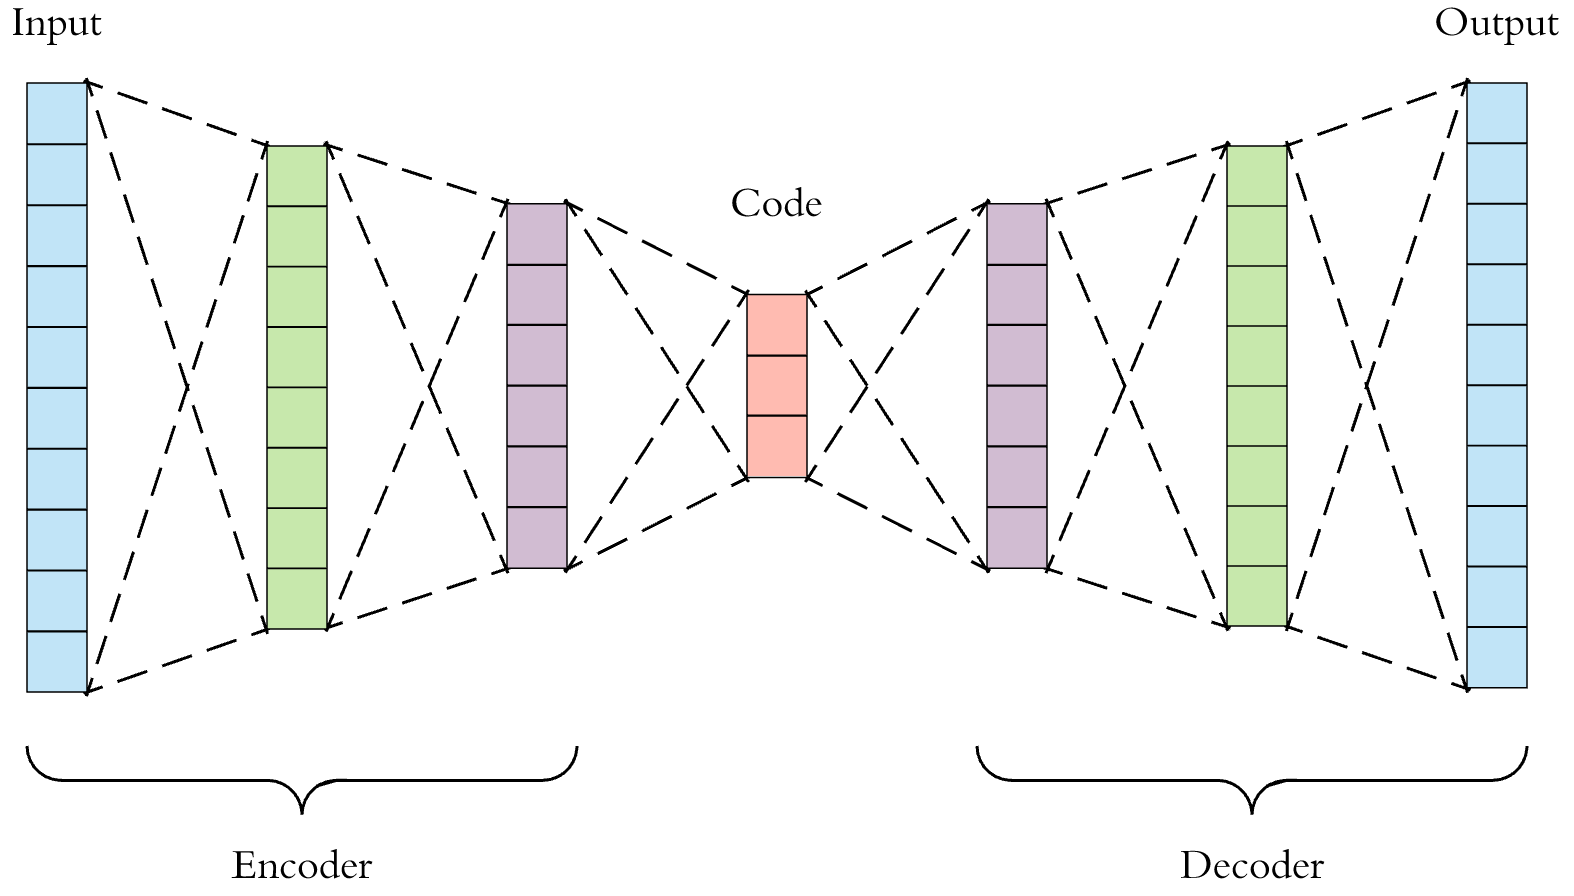

An autoencoder is a type of neural network that is trained to reconstruct the input data in an unsupervised manner. The architecture of an autoencoder typically consists of two parts: an encoder and a decoder.

The encoder takes the input data and maps it to a lower-dimensional representation, also known as the latent space (code). This is achieved by applying a series of linear and nonlinear transformations to the input data, resulting in a compressed representation of the input.

The decoder then takes the compressed representation from the latent space and maps it back to the original input space. This is achieved by applying a series of linear and nonlinear transformations to the compressed representation, resulting in a reconstruction of the input.

During training, the autoencoder is trained to minimize the reconstruction error between the original input and the reconstructed output. This is typically done by minimizing the mean squared error between the input and output.

The goal of training an autoencoder is to learn a compressed representation of the input that captures the most important features of the data. The learned representation can be used for various tasks such as data compression, feature extraction, and data denoising.

Once the autoencoder is trained, it can be used to compress new data by passing it through the encoder to obtain the compressed representation and then passing it through the decoder to obtain the reconstructed output.

## Load the dataset and Libraries


In [22]:
import numpy as np
import matplotlib.pyplot as plt  
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D, BatchNormalization

## A sample of the dataset
CIFAR-10 dataset is included in Keras.

In [2]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

print('Shape of x_train:', x_train.shape)
print('Shape of x_test:', x_test.shape)

170498071/170498071 [==============================] - 5s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of x_test: (10000, 32, 32, 3)


## Preprocess the data

### Normalize **[10 Points]**

Normalizing the pixel values of the images to the range [0, 1] or [-1, 1] helps to standardize the data and improve the performance of the model.

In [3]:
#Converting data points to float so we can normalize it
x_train = x_train.astype('float32')   
x_test = x_test.astype('float32')

#Normalizing the data between 0 and 1
x_train /= 255                        
x_test /= 255

print('Shape of x_train:', x_train.shape)
print('Shape of x_test:', x_test.shape)

Shape of x_train: (50000, 32, 32, 3)
Shape of x_test: (10000, 32, 32, 3)


### Split the training dataset **[10 Points]**
A common method for ensuring the generalization of the model is to split the training dataset two chucks, **training** and **validation** sets.

In [4]:
#Doing a 80:20 split for Train - Validation set
x_train, x_val = train_test_split(x_train,test_size=0.20)

print('Shape of x_train:', x_train.shape)
print('Shape of x_val:', x_val.shape)

Shape of x_train: (40000, 32, 32, 3)
Shape of x_val: (10000, 32, 32, 3)


## Design your model **[25 Points]**

Using the information in the beginning of this notebook, design an autoencoder using CNN layers.

*Hint:* For the encoder part you should use CNN layers (Conv2D in Keras), and for the decoder part you should use deconvolution layers (Conv2DTranspose in Keras).

*Suggestion:* To improve your code's readability and usability, you can use Keras' functional API instead of a sequential model. It allows you create two seperate models for the encoder and decoder parts. Take a look at Keras documentation on functional API: https://keras.io/guides/functional_api/#use-the-same-graph-of-layers-to-define-multiple-models

In [10]:
input_img = Input(shape=(32,32,3))

#Encoder
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding = 'same')(x)

x = Conv2D(16,(3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2,2), padding = 'same', name = 'encoder')(x)

#Decoder
x = Conv2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, (3, 3), activation = 'relu',padding = 'same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(3, (3, 3), activation = 'sigmoid', padding = 'same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'mse') # MSE is the appropriate choice for Deconstruction and Reconstruction
encoder = Model(input_img, encoded)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        9232      
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 16)       64  

## Train your model **[20 Points]**
Use the training set to train the model and use the validation set to monitor the traning process. Make sure to use an appropriate loss function considering your task (reconstruction loss) and model architecure.

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, verbose = 1)

# Providing x_train and x_test as labels as well since this is unsupervised learning
history = autoencoder.fit(x_train, x_train, epochs=10, verbose=1, validation_data = (x_val, x_val), batch_size = 512, callbacks=[early_stop])

Epoch 1/10
79/79 [==============================] - 181s 2s/step - loss: 0.0189 - val_loss: 0.0495
Epoch 2/10
79/79 [==============================] - 177s 2s/step - loss: 0.0094 - val_loss: 0.0425
Epoch 3/10
79/79 [==============================] - 181s 2s/step - loss: 0.0076 - val_loss: 0.0317
Epoch 4/10
79/79 [==============================] - 182s 2s/step - loss: 0.0065 - val_loss: 0.0205
Epoch 5/10
79/79 [==============================] - 179s 2s/step - loss: 0.0059 - val_loss: 0.0133
Epoch 6/10
79/79 [==============================] - 191s 2s/step - loss: 0.0055 - val_loss: 0.0091
Epoch 7/10
79/79 [==============================] - 183s 2s/step - loss: 0.0051 - val_loss: 0.0061
Epoch 8/10
79/79 [==============================] - 182s 2s/step - loss: 0.0049 - val_loss: 0.0052
Epoch 9/10
79/79 [==============================] - 180s 2s/step - loss: 0.0047 - val_loss: 0.0048
Epoch 10/10
79/79 [==============================] - 182s 2s/step - loss: 0.0045 - val_loss: 0.0048


## Plot the loss **[10 Points]**

Plot the trend of training loss and validation loss with respect to epochs. You should use visualization libraries (e.g. matplotlib, seaborn) to show these plots.

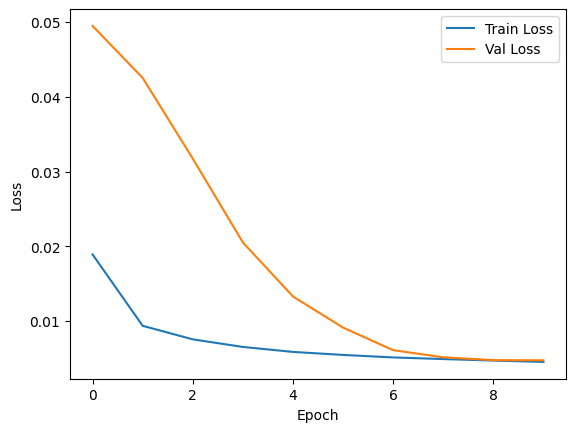

In [12]:
# Plotting Training Loss and Validation Loss with respect to Epochs
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    #plt.ylim([0, 1])

plot_history()

## Test the model on the test set **[10 Points]**
Once the autoencoder is trained, use it to compress the test data and measure the reconstruction error.

In [18]:
# Running the Autoencoder on the Test Set
predictions = autoencoder.predict(x_test)

# Flattening the images so that we can feed it to MSE
num_images = x_test.shape[0]
num_pixels = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
x_test_flat = x_test.reshape(num_images, num_pixels)
predictions_flat = predictions.reshape(num_images, num_pixels)

# Calculation Mean Squared Error
mse = mean_squared_error(x_test_flat, predictions_flat)
print("Mean Square Error is: ",mse)

313/313 [==============================] - 9s 30ms/step
0.0047547123


## Visualize **[15 Points]**

Visualize the compressed and reconstructed images for a few samples in the dataset and compare them to the original data to evaluate the quality of the compression.

313/313 [==============================] - 6s 18ms/step
Showing Below Original, Encoded and Decoded Images



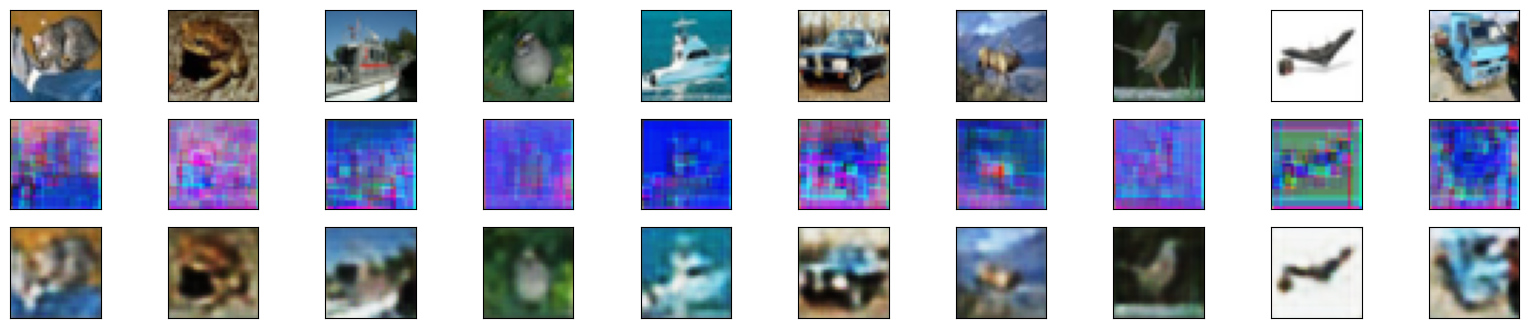

In [31]:
n = 10
plt.figure(figsize=(20, 4))

# Running the Encoder on Test images
encoded_imgs = encoder.predict(x_test)

# Matching the shape of the encoded images to the original and Decoded images
compressed_img = UpSampling2D((4, 4))(encoded_imgs)
compressed_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(compressed_img)

# Plotting the Original, COmpressed and Reconstructed images 
print("Showing Below Original, Encoded and Decoded Images\n")

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[300*i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display compressed
    ax = plt.subplot(3, n, i+1 + n)
    plt.imshow(compressed_img[300*i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i +1 + 2*n)
    plt.imshow(predictions[300*i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()